In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset_unet import prepare_trainset
from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.model_unet_multitask import UNetResNet34, predict_proba

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 1234#5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = 512
BATCH_SIZE = 4
NUM_WORKERS = 24
warm_start, last_checkpoint_path = False, 'checkpoint/%s_%s_v1_seed%s/best.pth.tar'%(MODEL, IMG_SIZE, SEED)
checkpoint_path = 'checkpoint/multitask_%s_%s_v1_seed%s'%(MODEL, IMG_SIZE, SEED)
LOG_PATH = 'logging/multitask_%s_%s_v1_seed%s.log'%(MODEL, IMG_SIZE, SEED)#
torch.cuda.manual_seed_all(SEED)

NUM_EPOCHS = 100
early_stopping_round = 10#500#50
LearningRate = 0.02#phase1: 0.02, phase2: 0.002

====MODEL ACHITECTURE: UNetResNet34====


## the dataset

In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count of trainset (for training):  900
Count of validset (for training):  100


In [4]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    if i==0:
        break

In [5]:
images.size(), masks.size()

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

In [6]:
#define non-empty-mask as 1
truth_clf = (masks.sum(dim=2).sum(dim=2)!=0).float()

In [8]:
truth_clf.size()

torch.Size([4, 1])

In [7]:
truth_clf

tensor([[0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

## the model

In [8]:
net = UNetResNet34(debug=True).cuda(device=device)

#torch.cuda.set_device(0)
#torch.distributed.init_process_group(backend='nccl', world_size=4, init_method='...')
#net = DistributedDataParallel(net, device_ids=[0], output_device=0)
#torch.distributed.init_process_group(backend="nccl")

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

#checkpoint_path = 'checkpoint/UNetResNet34_256_v1_seed1234/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

In [9]:
logit_mask, logit_clf = net(images)

input:  torch.Size([4, 3, 512, 512])
e1 torch.Size([4, 64, 256, 256])
e2 torch.Size([4, 64, 256, 256])
e3 torch.Size([4, 128, 128, 128])
e4 torch.Size([4, 256, 64, 64])
e5 torch.Size([4, 512, 32, 32])
center torch.Size([4, 256, 16, 16])
d5 torch.Size([4, 64, 32, 32])
d4 torch.Size([4, 64, 64, 64])
d3 torch.Size([4, 64, 128, 128])
d2 torch.Size([4, 64, 256, 256])
d1 torch.Size([4, 64, 512, 512])
hypercolum torch.Size([4, 320, 512, 512])
logit_mask torch.Size([4, 1, 512, 512])
avgpool torch.Size([4, 256, 1, 1])
reshape torch.Size([4, 256])
logit_clf torch.Size([4, 1])


/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [10]:
loss, loss_mask, loss_clf = net.criterion(logit_mask, masks, logit_clf, truth_clf)
loss, loss_mask, loss_clf

(tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1681, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [39]:
torch.sigmoid(logit_mask).view(4, -1) * (torch.sigmoid(logit_clf).view(4, -1)>0.75).float()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<MulBackward0>)

In [12]:
_metric = net.metric(logit_mask, masks)
_metric

tensor(0.0375, device='cuda:0')

In [28]:
# i = 1

# fig = plt.figure(figsize=(8, 5))
# if masks[i].mean()==0:
#     plt.title('Empty mask')
# else:
#     plt.title('See marker')

# ax = fig.add_subplot(1, 2, 1)
# plt.imshow(image.cpu().numpy()[i][0], cmap=plt.cm.bone)
# plt.imshow(masks.cpu().numpy()[i][0], alpha=0.3, cmap="Reds")

# ax = fig.add_subplot(1, 2, 2)
# plt.imshow(image.cpu().numpy()[i][0], cmap=plt.cm.bone)
# plt.imshow((logit>0).float().cpu().detach().numpy()[i][0], alpha=0.3, cmap="Reds")

## the training

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from dataset_unet import prepare_trainset
from model.model_unet_multitask import UNetResNet34, predict_proba


%matplotlib inline

In [2]:
######### Define the training process #########
def run_check_net(train_dl, val_dl, multi_gpu=[0, 1]):
    set_logger(LOG_PATH)
    logging.info('\n\n')
    #---
    if MODEL == 'UNetResNet34':
        net = UNetResNet34(debug=False).cuda(device=device)
    #elif MODEL == 'RESNET18':
    #    net = AtlasResNet18(debug=False).cuda(device=device)

#     for param in net.named_parameters():
#         if param[0][:8] in ['decoder5']:#'decoder5', 'decoder4', 'decoder3', 'decoder2'
#             param[1].requires_grad = False

    # dummy sgd to see if it can converge ...
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                      lr=LearningRate, momentum=0.9, weight_decay=0.0001)
    #optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.045)#LearningRate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                           factor=0.5, patience=4,#4 resnet34 
                                                           verbose=False, threshold=0.0001, 
                                                           threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-08)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.9, last_epoch=-1)
    
    if warm_start:
        logging.info('warm_start: '+last_checkpoint_path)
        net, _ = load_checkpoint(last_checkpoint_path, net)
    
    # using multi GPU
    if multi_gpu is not None:
        net = nn.DataParallel(net, device_ids=multi_gpu)

    diff = 0
    best_val_metric = -0.1
    optimizer.zero_grad()
    
    #seed = get_seed()
    #seed = SEED
    #logging.info('aug seed: '+str(seed))
    #ia.imgaug.seed(seed)
    #np.random.seed(seed)
    
    for i_epoch in range(NUM_EPOCHS):
        t0 = time.time()
        # iterate through trainset
        if multi_gpu is not None:
            net.module.set_mode('train')
        else:
            net.set_mode('train')
        train_loss_list = []
        train_loss_mask_list = []
        train_loss_clf_list = []
        train_metric_list = []
        #for seed in [1]:#[1, SEED]:#augment raw data with a duplicate one (augmented)
        #seed = get_seed()
        #np.random.seed(seed)
        #ia.imgaug.seed(i//10)
        for i, (image, masks) in enumerate(train_dl):
            input_data = image.to(device=device, dtype=torch.float)
            truth_mask = masks.to(device=device, dtype=torch.float)
            #define non-empty-mask as 1
            truth_clf = (truth_mask.sum(dim=2).sum(dim=2)!=0).float()
            #set_trace()
            logit_mask, logit_clf = net(input_data)#[:, :3, :, :]
            
            if multi_gpu is not None:
                _train_loss, _train_loss_mask, _train_loss_clf = net.module.criterion(logit_mask, truth_mask, logit_clf, truth_clf)
                _train_metric = net.module.metric(logit_mask, truth_mask)#device='gpu'
            else:
                _train_loss, _train_loss_mask, _train_loss_clf = net.criterion(logit_mask, truth_mask, logit_clf, truth_clf)
                _train_metric  = net.metric(logit_mask, truth_mask)#device='gpu'
            train_loss_list.append(_train_loss.item())
            train_loss_mask_list.append(_train_loss_mask.item())
            train_loss_clf_list.append(_train_loss_clf.item())
            train_metric_list.append(_train_metric.item())#.detach()

            #grandient accumulation step=2
            acc_step = 2
            _train_loss = _train_loss / acc_step
            _train_loss.backward()
            if (i+1)%acc_step==0:
                optimizer.step()
                optimizer.zero_grad()

        train_loss = np.mean(train_loss_list)
        train_loss_mask = np.mean(train_loss_mask_list)
        train_loss_clf = np.mean(train_loss_clf_list)
        train_metric = np.mean(train_metric_list)

        # compute valid loss & metrics (concatenate valid set in cpu, then compute loss, metrics on full valid set)
        net.module.set_mode('valid')
        with torch.no_grad():
#             val_loss_list, val_metric_list = [], []
#             for i, (image, masks) in enumerate(val_dl):
#                 input_data = image.to(device=device, dtype=torch.float)
#                 truth = masks.to(device=device, dtype=torch.float)
#                 logit = net(input_data)
                
#                 if multi_gpu is not None:
#                     _val_loss  = net.module.criterion(logit, truth)
#                     _val_metric  = net.module.metric(logit, truth)#device='gpu'
#                 else:
#                     _val_loss  = net.criterion(logit, truth)
#                     _val_metric  = net.metric(logit, truth)#device='gpu'
#                 val_loss_list.append(_val_loss.item())
#                 val_metric_list.append(_val_metric.item())#.detach()

#             val_loss = np.mean(val_loss_list)
#             val_metric = np.mean(val_metric_list)
            
            logit_mask_valid, logit_clf_valid, truth_mask_valid, truth_clf_valid = None, None, None, None
            for j, (image, masks) in enumerate(val_dl):
                input_data = image.to(device=device, dtype=torch.float)
                truth_mask = masks.cpu().float()
                #define non-empty-mask as 1
                truth_clf = (truth_mask.sum(dim=2).sum(dim=2)!=0).cpu().float()
                logit_mask, logit_clf = net(input_data)
                logit_mask, logit_clf = logit_mask.cpu().float(), logit_clf.cpu().float()
                if logit_mask_valid is None:
                    logit_mask_valid = logit_mask
                    logit_clf_valid = logit_clf
                    truth_mask_valid = truth_mask
                    truth_clf_valid = truth_clf
                else:
                    logit_mask_valid = torch.cat((logit_mask_valid, logit_mask), dim=0)
                    logit_clf_valid = torch.cat((logit_clf_valid, logit_clf), dim=0)
                    truth_mask_valid = torch.cat((truth_mask_valid, truth_mask), dim=0)
                    truth_clf_valid = torch.cat((truth_clf_valid, truth_clf), dim=0)
            if multi_gpu is not None:
                val_loss, val_loss_mask, val_loss_clf = net.module.criterion(logit_mask_valid, truth_mask_valid, logit_clf_valid, truth_clf_valid)
                val_metric = net.module.metric(logit_mask_valid, truth_mask_valid)
            else:
                val_loss, val_loss_mask, val_loss_clf = net.criterion(logit_mask_valid, truth_mask_valid, logit_clf_valid, truth_clf_valid)
                val_metric = net.metric(logit_mask_valid, truth_mask_valid)

        # Adjust learning_rate
        scheduler.step(val_metric)
        #
        if val_metric > best_val_metric:
            best_val_metric = val_metric
            is_best = True
            diff = 0
        else:
            is_best = False
            diff += 1
            if diff > early_stopping_round:
                logging.info('Early Stopping: val_metric does not increase %d rounds'%early_stopping_round)
                #print('Early Stopping: val_iou does not increase %d rounds'%early_stopping_round)
                break
        
        #save checkpoint
        checkpoint_dict = \
        {
            'epoch': i,
            'state_dict': net.module.state_dict() if multi_gpu is not None else net.state_dict(),
            'optim_dict' : optimizer.state_dict(),
            'metrics': {'train_loss': train_loss, 'val_loss': val_loss, 
                        'train_metric': train_metric, 'val_metric': val_metric}
        }
        save_checkpoint(checkpoint_dict, is_best=is_best, checkpoint=checkpoint_path)

        #if i_epoch%20==0:
        if i_epoch>-1:
            logging.info('[EPOCH %05d]train_loss_mask, train_loss_clf, train_metric: %0.5f, %0.5f, %0.5f; val_loss_mask, val_loss_clf, val_metric: %0.5f, %0.5f, %0.5f; time elapsed: %0.1f min'%(i_epoch, train_loss_mask.item(), train_loss_clf.item(), train_metric.item(), val_loss_mask.item(), val_loss_clf.item(), val_metric.item(), (time.time()-t0)/60))


In [3]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("1, 2", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0, 1]#use 2 gpus

SEED = 1234#5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = 24
warm_start, last_checkpoint_path = False, 'checkpoint/%s_%s_v1_seed%s/best.pth.tar'%(MODEL, IMG_SIZE, SEED)
checkpoint_path = 'checkpoint/multitask_%s_%s_v1_seed%s'%(MODEL, IMG_SIZE, SEED)
LOG_PATH = 'logging/multitask_%s_%s_v1_seed%s.log'%(MODEL, IMG_SIZE, SEED)#
torch.cuda.manual_seed_all(SEED)

NUM_EPOCHS = 100
early_stopping_round = 10#500#50
LearningRate = 0.02#phase1: 0.02, phase2: 0.002

====MODEL ACHITECTURE: UNetResNet34====


In [4]:
######### Load data #########
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

######### Run the training process #########
run_check_net(train_dl, val_dl, multi_gpu=multi_gpu)

Count of trainset (for training):  900
Count of validset (for training):  100





/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
[EPOCH 00000]train_loss_mask, train_loss_clf, train_metric: 0.07749, 0.66904, 0.70538; val_loss_mask, val_loss_clf, val_metric: 0.02297, 0.56849, 0.77083; time elapsed: 1.3 min
[EPOCH 00001]train_loss_mask, train_loss_clf, train_metric: 0.01710, 0.53081, 0.79167; val_loss_mask, val_loss_clf, val_metric: 0.01845, 0.53771, 0.77083; time elapsed: 1.2 min
[EPOCH 00002]train_loss_mask, train_loss_clf, train_metric: 0.01595, 0.51189, 0.79167; val_loss_mask, val_loss_clf,

KeyboardInterrupt: 

## predict the validset, and analyse

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.model_unet_multitask import UNetResNet34, predict_proba
from dataset_unet import prepare_trainset

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 3456#5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = 24

====MODEL ACHITECTURE: UNetResNet34====


In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count of trainset (for training):  9607
Count of validset (for training):  1068


In [4]:
# y should be makeup
valid_mask, valid_clf = [], []
for i, (image, masks) in enumerate(val_dl):
    truth_mask = masks#.to(device=device, dtype=torch.float)
    truth_clf = (truth_mask.sum(dim=2).sum(dim=2)!=0).cpu().float().numpy()
    valid_mask.append(truth_mask)
    valid_clf.append(truth_clf)

valid_mask = np.concatenate(valid_mask, axis=0)
valid_clf = np.concatenate(valid_clf, axis=0)
valid_mask.shape, valid_clf.shape

((1064, 1, 512, 512), (1064, 1))

In [5]:
net = UNetResNet34(debug=False).cuda(device=device)

In [6]:
checkpoint_path = 'checkpoint/multitask_UNetResNet34_512_v2_seed3456/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

In [7]:
%%time
# predict_proba
net.set_mode('valid')#.module
preds_mask, preds_clf = predict_proba(net, val_dl, device, multi_gpu=False, mode='valid', tta=True)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 17min 46s, sys: 2min 57s, total: 20min 43s
Wall time: 1min 32s


In [8]:
preds_mask.shape, preds_clf.shape

((1064, 512, 512), (1064, 1))

In [9]:
## search for best thresholds
def calculate_dice(logit_mask, logit_clf, truth_mask, 
                   CLF_NONEMPTY_THRESHOLD=0.75, MASK_THRESHOLD=0.22, EMPTY_THRESHOLD=400):
    IMG_SIZE = logit_mask.shape[-1] #512
    logit_mask = sigmoid(logit_mask)#.reshape(n, -1)
    pred_mask = (logit_mask>MASK_THRESHOLD).astype(np.int)
    logit_clf = sigmoid(logit_clf)
    #option 1
    pred_clf = (logit_clf>CLF_NONEMPTY_THRESHOLD).astype(np.int)
    pred_mask[pred_clf.reshape(-1,)==0, ] = 0
    #option 2
    #pred_clf = (pred_mask.reshape(pred_mask.shape[0], -1).sum(axis=1)<EMPTY_THRESHOLD).astype(np.int)
    #pred_mask[pred_clf.reshape(-1,)==1, ] = 0
    return dice_overall(pred_mask, truth_mask)

def dice_overall(pred_mask, truth_mask, eps=1e-8):
    n = pred_mask.shape[0]
    pred_mask = pred_mask.reshape(n, -1)
    truth_mask = truth_mask.reshape(n, -1)
    intersect = (pred_mask * truth_mask).sum(axis=1).astype(np.float)
    union = (pred_mask + truth_mask).sum(axis=1).astype(np.float)
    return ((2.0*intersect + eps) / (union+eps)).mean()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [28]:
CLF_NONEMPTY_THRESHOLD_candidate = np.arange(0.69, 0.71, 0.01)
#EMPTY_THRESHOLD_candidate = np.arange(1440, 1540, 20)#np.arange(350, 450, 10) for IMG_SIZE=256
MASK_THRESHOLD_candidate = np.arange(0.3, 0.4, 0.02)
#M, N = len(EMPTY_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
M, N = len(CLF_NONEMPTY_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
best_threshold = None
best_score = 0

for i in tqdm_notebook(range(M)):
    CLF_NONEMPTY_THRESHOLD = CLF_NONEMPTY_THRESHOLD_candidate[i]
    #EMPTY_THRESHOLD = EMPTY_THRESHOLD_candidate[i]
    for j in range(N):
        MASK_THRESHOLD = MASK_THRESHOLD_candidate[j]
        dice_score = calculate_dice(preds_mask, preds_clf, valid_mask.squeeze(1), 
                                    CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, None)
        print('CLF_NONEMPTY_THRESHOLD: %f, MASK_THRESHOLD: %f, dice_score: %f'%(CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, dice_score))
        #print('EMPTY_THRESHOLD: %f, MASK_THRESHOLD: %f, dice_score: %f'%(EMPTY_THRESHOLD, MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            #best_threshold = [EMPTY_THRESHOLD, MASK_THRESHOLD]
            best_threshold = [CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD]
            best_score = dice_score

CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.300000, dice_score: 0.828422
CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.320000, dice_score: 0.828889
CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.340000, dice_score: 0.829131
CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.360000, dice_score: 0.829294
CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.380000, dice_score: 0.829329
CLF_NONEMPTY_THRESHOLD: 0.690000, MASK_THRESHOLD: 0.400000, dice_score: 0.829202
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.300000, dice_score: 0.830302
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.320000, dice_score: 0.830769
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.340000, dice_score: 0.831011
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.360000, dice_score: 0.831174
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.380000, dice_score: 0.831208
CLF_NONEMPTY_THRESHOLD: 0.700000, MASK_THRESHOLD: 0.400000, dice_score: 0.831081
CLF_NONEMPTY_THRESHOLD: 0.71

In [29]:
# EMPTY_THRESHOLD, MASK_THRESHOLD = best_threshold
# EMPTY_THRESHOLD, MASK_THRESHOLD, best_score
CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD = best_threshold
CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, best_score

(0.7, 0.38000000000000006, 0.8312083418598146)

In [30]:
def predict_mask(logit_mask, logit_clf, CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, EMPTY_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    IMG_SIZE = logit_mask.shape[-1] #256
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    
    logit_mask = sigmoid(logit_mask)#.reshape(n, -1)
    pred_mask = (logit_mask>MASK_THRESHOLD).astype(np.int)
    logit_clf = sigmoid(logit_clf)
    pred_clf = (logit_clf>CLF_NONEMPTY_THRESHOLD).astype(np.int)

    if pred_clf==0:
        return np.zeros(pred_mask.shape).astype(np.int)
    else:
        return pred_mask

#     logit_mask = sigmoid(logit_mask)#.reshape(n, -1)
#     pred_mask = (logit_mask>MASK_THRESHOLD).astype(np.int)
    
#     if pred_mask.sum() < EMPTY_THRESHOLD:
#         return np.zeros(pred_mask.shape).astype(np.int)
#     else:
#         return pred_mask

In [34]:
## visualize predicted masks
rows = 10

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    for j in range(BATCH_SIZE):
        not_empty = mask[j][0].sum()>0
        if not_empty:
            cnt+=1
            pred_mask = predict_mask(preds_mask[idx*BATCH_SIZE+j], preds_clf[idx*BATCH_SIZE+j], CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, None)
#             pred_clf = sigmoid()
#             if pred_clf>0.85:
#                 pred_empty = True
#             else:
#                 pred_empty = False
            #if pred_mask.sum()==0:
            #    continue
            fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
            ax0.imshow(img[j][0].numpy(), plt.cm.bone)
            ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
            ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
            if not_empty.item():
                ax1.set_title('Targets(Has Mask)')
            else:
                ax1.set_title('Targets(Empty)')
            if pred_mask.sum()==0:#pred_empty:
                ax2.set_title('Predict Empty')
            else:
                ax2.set_title('Predict Mask')
            ax0.set_title('idx=%d'%(idx*16+j))
        if cnt>rows:
            break
    if cnt>rows:
            break

In [23]:
from metrics import dice

In [31]:
dice(torch.from_numpy(np.expand_dims(preds_valid, 1)), torch.from_numpy(y_valid))

tensor(0.8263)

In [ ]:
y_valid.shape, preds_valid.shape

In [44]:
dice(torch.zeros(y_valid.shape), torch.from_numpy(y_valid))

tensor(0.8021)

## predict the testset

In [35]:
import glob
from dataset_unet import prepare_testset

In [36]:
test_fnames = [f.split('/')[-1][:-4] for f in glob.glob('data/processed/test/*')]
len(test_fnames), test_fnames[0]

(1377, '1.2.276.0.7230010.3.1.4.8323329.6160.1517875196.806852')

In [37]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [38]:
%%time
preds_mask, preds_clf = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


CPU times: user 24min 3s, sys: 4min 18s, total: 28min 21s
Wall time: 2min 3s


In [39]:
preds_mask.shape, preds_clf.shape

((1377, 512, 512), (1377, 1))

In [1]:
## visualize predicted masks
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, img in enumerate(test_dl):
    for j in range(BATCH_SIZE):#BATCH_SIZE
        cnt+=1
        pred_mask = predict_mask(preds_mask[idx*BATCH_SIZE+j], preds_clf[idx*BATCH_SIZE+j], 
                                 CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, None)
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(img[j][0].numpy(), plt.cm.bone)
        plt.imshow(pred_mask, alpha=0.3, cmap="Reds")
        if pred_mask.sum()>0:
            plt.title('Predict Mask')
        else:
            plt.title('Predict Empty')
        if cnt>total:
            break
    if cnt>total:
            break

## build submission

In [46]:
import PIL
from mask_functions import mask2rle

In [47]:
preds_mask.shape, preds_clf.shape

((1377, 512, 512), (1377, 1))

In [48]:
#### Step 1: Generate rle encodings (images are first converted to the original size)
rles = []
for idx in tqdm_notebook(range(preds_mask.shape[0])):#p is logit from model
    pred_mask, pred_clf = preds_mask[idx], preds_clf[idx]
    pred_mask = predict_mask(pred_mask, pred_clf, CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, None)
    if pred_mask.sum()>0:#predicted non-empty mask
        im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        rles.append(mask2rle(im, 1024, 1024))
    else: rles.append('-1')
    
sub_df = pd.DataFrame({'ImageId': test_fnames, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()

1377


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,622766 2 1022 2 1018 10 2 8 1004 10 2 8 1002 2...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,248092 6 6 2 1010 6 6 2 1006 8 1016 8 1012 12 ...


In [49]:
# check the correctness of transformation before submit
i = 22
pred_mask = predict_mask(preds_mask[i], preds_clf[i], CLF_NONEMPTY_THRESHOLD, MASK_THRESHOLD, None)
im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
im = np.asarray(im)
im.max()

255

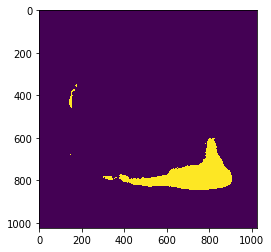

In [50]:
plt.imshow(im)

In [51]:
sub_df.to_csv('submission/0722_multitask_unet_512_v2_seed3456.csv.gz', index=False, compression='gzip')

In [104]:
from scipy import ndimage

In [105]:
#### Step 2: the sub is Instance Segmentation, so need to split mask into instances of masks
def split_mask(mask):
    MASK_THRESHOLD = 0.22
    EMPTY_THRESHOLD = 30 #ignore predictions composed of 30 pixels or less
    #split disconnected masks with ndimage.label function
    labled,n_objs = ndimage.label(mask > MASK_THRESHOLD)
    result = []
    n_pixels = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if obj.sum() > EMPTY_THRESHOLD:
            result.append(obj)
            n_pixels.append(obj.sum())
    #sort masks based on the number of pixels
    result = [x for _,x in sorted(zip(n_pixels,result),reverse=True,key=lambda x:x[0])]
    return result

In [107]:
%%time
rles = []
ids_c = []
for p,idx in tqdm_notebook(zip(preds_test, test_fnames), total=len(preds_test)):
    pred_mask = predict_mask(p)
    if pred_mask.sum() > 0:
        masks = split_mask(pred_mask)#to_np
        for mask in masks:
            ids_c.append(idx)
            im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((1024,1024))
            im = np.asarray(im)
            rles.append(mask2rle(im, 1024, 1024))
        if len(masks) == 0:
            rles.append('-1')
            ids_c.append(idx)
    else: 
        rles.append('-1')
        ids_c.append(idx)


CPU times: user 3min 11s, sys: 3.99 s, total: 3min 15s
Wall time: 2min 14s


In [108]:
sub_df = pd.DataFrame({'ImageId': ids_c, 'EncodedPixels': rles})
print(len(sub_df))
sub_df.head()

1454


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,602280 20 1004 20 1004 20 1004 20 996 56 968 5...
2,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,844468 8 1016 8 1016 8 1016 8 1016 8 1016 8 10...
3,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1


In [109]:
sub_df.to_csv('submission/0708_unet_seed1234_split.csv.gz', index=False, compression='gzip')